In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import torchvision.utils as vutils

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
from torch.autograd import Variable
from PIL import Image
toTensor = transforms.ToTensor()

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class_names

['Left_Index',
 'Left_Little',
 'Left_Middle',
 'Left_Ring',
 'Left_Thumb',
 'Right_Index',
 'Right_Little',
 'Right_Middle',
 'Right_Ring',
 'Right_Thumb']

In [8]:
t_loss = []
v_loss = []

actual = []
pred = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
#                     outputs = outputs.cpu()
#                     index = outputs.data.numpy().argmax()
#                     pred.append(index)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                t_loss.append(epoch_loss)
            else:
                v_loss.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

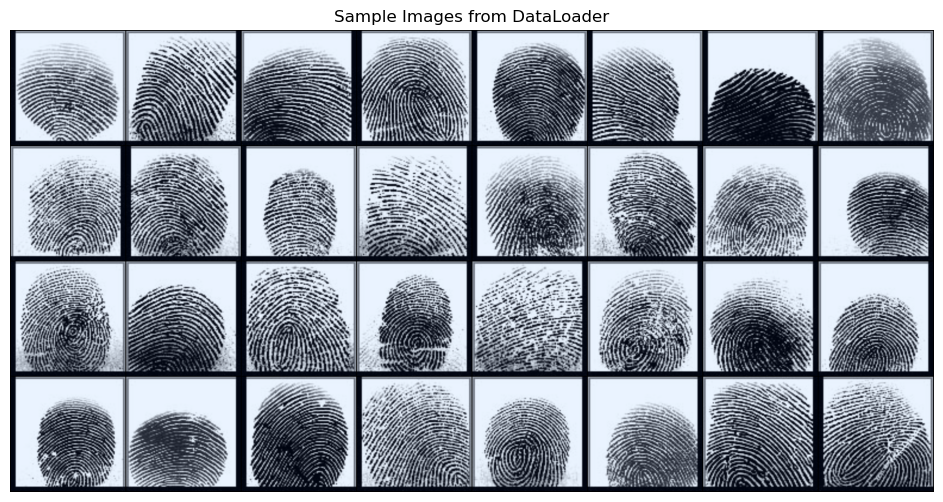

In [9]:
# Get a batch of data from the DataLoader
data_iter = iter(dataloaders['train'])
images, labels = next(data_iter)

# Convert the PyTorch tensor to NumPy for visualization
image_grid = vutils.make_grid(images, nrow=8, padding=2, normalize=True)

# Display the image grid using Matplotlib
plt.figure(figsize=(12, 6))
plt.axis("off")
plt.title("Sample Images from DataLoader")
plt.imshow(image_grid.permute(1, 2, 0))  # Permute dimensions for correct visualization
plt.show()

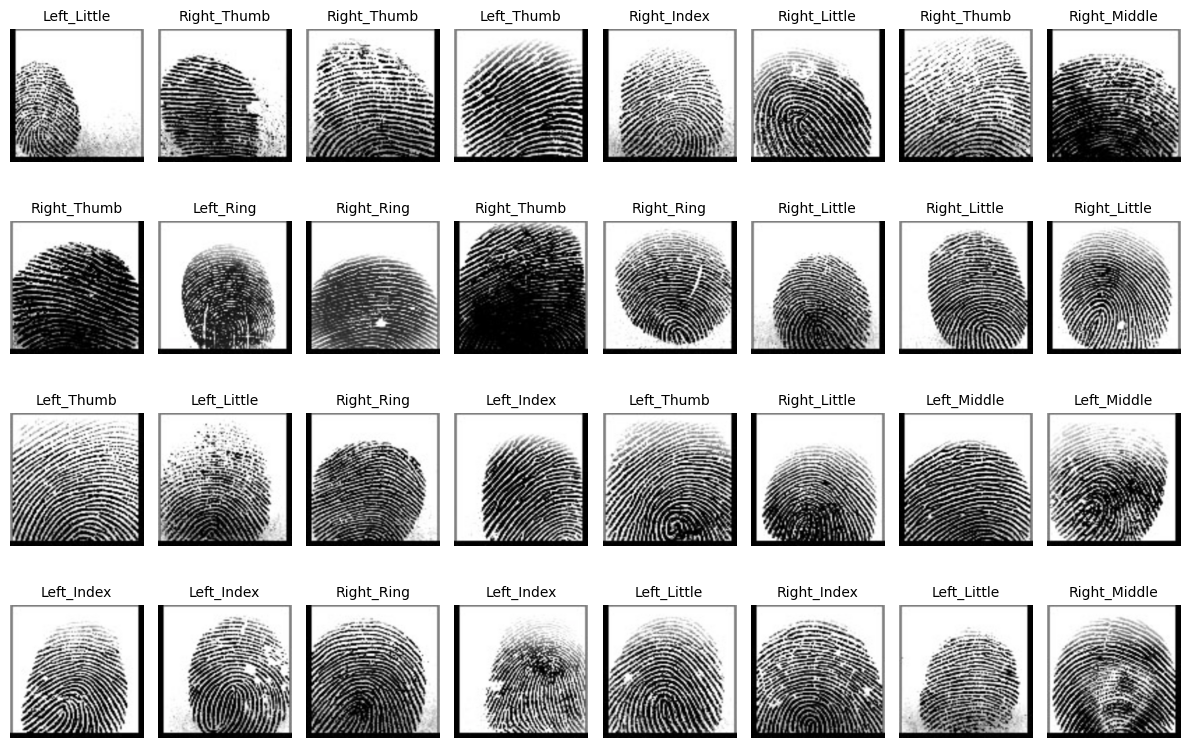

In [10]:
data_iter = iter(dataloaders['train'])
images, labels = next(data_iter)

# Denormalize the images (if normalization was applied)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images = images * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

# Create a grid of images with labels
image_grid = torchvision.utils.make_grid(images, nrow=8, padding=2)
class_labels = [class_names[label] for label in labels.numpy()]

# Display the image grid with labels using Matplotlib
plt.figure(figsize=(12, 8))

# Display class labels along with each image
for i in range(len(class_labels)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for correct visualization
    plt.title(class_labels[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


train Loss: 1.9155 Acc: 0.3036
val Loss: 1.5411 Acc: 0.4429

Epoch 1/24
----------
train Loss: 1.4158 Acc: 0.4760
val Loss: 1.2959 Acc: 0.5314

Epoch 2/24
----------
train Loss: 1.1308 Acc: 0.5905
val Loss: 1.0992 Acc: 0.6150

Epoch 3/24
----------
train Loss: 0.8999 Acc: 0.6860
val Loss: 0.9638 Acc: 0.6457

Epoch 4/24
----------
train Loss: 0.7206 Acc: 0.7569
val Loss: 0.8830 Acc: 0.6786

Epoch 5/24
----------
train Loss: 0.5581 Acc: 0.8164
val Loss: 0.8753 Acc: 0.6786

Epoch 6/24
----------
train Loss: 0.4407 Acc: 0.8600
val Loss: 0.9251 Acc: 0.6757

Epoch 7/24
----------
train Loss: 0.2980 Acc: 0.9188
val Loss: 0.7723 Acc: 0.7164

Epoch 8/24
----------
train Loss: 0.2425 Acc: 0.9419
val Loss: 0.7608 Acc: 0.7257

Epoch 9/24
----------
train Loss: 0.2221 Acc: 0.9479
val Loss: 0.7501 Acc: 0.7343

Epoch 10/24
----------
train Loss: 0.1892 Acc: 0.9590
val Loss: 0.7804 Acc: 0.7136

Epoch 11/24
----------
train Loss: 0.1839 Acc: 0.9626
val Loss: 0.7612 Acc: 0.7271

Epoch 12/24
----------
t

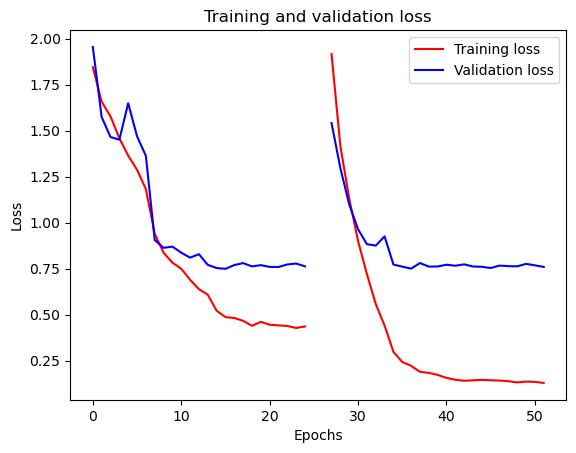

In [18]:
plt.plot( t_loss, 'r', label='Training loss')
plt.plot(v_loss, 'b', label='Validation loss')

# plt.plot(best_epoch_train_loss, 'g', label='Best loss')
# plt.plot( train_loss_arr, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()